## Neuron Simulation and Modeling

This is a Jupyter Notebook that I worked on implementing the different features. I ended up executing the results in notebook called "execution-of-neural-simulation.ipynb".

In [184]:
# Necessary Imports
import numpy as np
import pandas as pd
from collections import namedtuple
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import matplotlib.cm as cm
import matplotlib.colors as c

# Analysis
import pysindy as ps

# Own imports from utils file
from utils import *
from visualizations import *

# 7. Program a simulation

Program a simulation of at least 3 neurons. 

**The point here is to implement reasonable facsimiles of different features of neurons that could impact how the system functions. For each feature, demonstrate how it impacts the system (this does not need to be elaborate, just showing the relevant interesting bits is sufficient).**. For example, one can simulate the spatial embeddedness of neurons and their component axons and dendrites computationally by expressing the synapse weights as functions of geometric overlap of axon/dendrite “clouds.” 

Potential features of neurons to look at: it could be things like moderation via neurotransmitters, different types of neurons, actual timing of dynamics that represent physical distance, etc., etc., etc.

Pick something/things of interest to you, implement it, and write your rationale/justification for how you chose to operationalize a biological feature.

**Specific Goals:** I want to see how you translate the biological complexity of what you have been reading about into reasonable computational models. They don’t need to do anything per say, just show some interesting dynamics and show me you understand how to examine differences in those dynamics.

### Network Simulation

#### Simulation Parameters

In [185]:
# Loading in the configuration file
config_dict = LoadYAMLFile('config-file.yaml')

# Reproducibility
seed = config_dict['general']['seed']

# Neurons and Their Physical Environment
n = config_dict['general']['n'] # Number of neurons
n_dim = config_dict['general']['n_dim'] # Number of dimensions for the physical space that the neurons inhabit
radius = config_dict['general']['radius'] # Width of the physical space that the neurons can inhabit in each dimension. Equidistant in all dimensions. 
distance_connection_probability_exponent = config_dict['general']['distance_connection_probability_exponent']

# Configuration style
implement_nueron_modules_positions = True
implement_neuron_modules_connections = True

# Booleans for visualizations
visualize_nodal_positions_without_edges = True 
visualize_adjacency_matrix = True
visualize_connected_network = True

# Image Paths
base_path = 'figures/'
adjacency_matrix = base_path + 'adjacency-matrix-heatmap.png'
network_graph_path = base_path + 'network-graph.png'

KeyError: 'distance_connection_probability_exponent'

#### Generating Random Neuron Positions

In [46]:
# Create positions for the neurons in a physical space
if not implement_nueron_modules_positions:
    np.random.seed(seed)
    pos_array = np.random.rand(n, n_dim) * radius

elif implement_nueron_modules_positions:
    # Make 3 seperate groups
    num_groups = 3
    n_per_group = 100
    n = n_per_group * num_groups
    np.random.seed(seed)
    
    std = 0.05 # Standard deviation of each group
    
    x1_mean = 0.9 
    x2_mean = 0.6
    x3_mean = 0.9
    
    y1_mean = 0.3
    y2_mean = 0.6
    y3_mean = 0.9
    
    x1 = np.random.normal(loc = x1_mean, scale = std, size = n_per_group)
    x2 = np.random.normal(loc = x2_mean, scale = std, size = n_per_group)
    x3 = np.random.normal(loc = x3_mean, scale = std, size = n_per_group) 
    
    y1 = np.random.normal(loc = y1_mean, scale = std, size = n_per_group)
    y2 = np.random.normal(loc = y2_mean, scale = std, size = n_per_group)
    y3 = np.random.normal(loc = y3_mean, scale = std, size = n_per_group)
    
    # Pair them together 
    xs = np.concat([x1, x2, x3])
    ys = np.concat([y1, y2, y3])
    pos_array = np.column_stack([xs, ys]) * radius

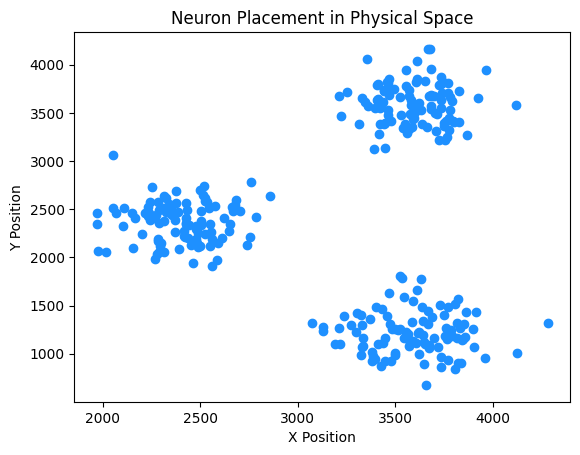

In [47]:
# Look at the neuronal positions if desired
if visualize_nodal_positions_without_edges:
    plt.scatter(pos_array[:, 0], pos_array[:, 1], color = 'dodgerblue')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Neuron Placement in Physical Space')
    
    plt.show()

In [48]:
# Create a function for generating the node positions
def GeneratePosArray(
    implement_nueron_modules_positions,
    n_dim = 2,
    radius = 4000,
    num_groups = 3,
    n_per_group = 100,
    seed = 2302,
    std = 0.05,
    x1_mean = 0.9, 
    x2_mean = 0.6,
    x3_mean = 0.9,
    y1_mean = 0.3,
    y2_mean = 0.6,
    y3_mean = 0.9,
):
    '''
    A general function for creating the positions array.

    Parameters:
    ----------
        implement_nueron_modules_positions: A boolean to decide if the neurons should be clustered in modules or randomly dispered in the physical space.
        
    '''
    # Create positions for the neurons in a physical space
    if not implement_nueron_modules_positions:
        np.random.seed(seed)
        pos_array = np.random.rand(n, n_dim) * radius
    
    elif implement_nueron_modules_positions:
        # Make 3 seperate groups
        n = n_per_group * num_groups
        np.random.seed(seed)    
        
        x1 = np.random.normal(loc = x1_mean, scale = std, size = n_per_group)
        x2 = np.random.normal(loc = x2_mean, scale = std, size = n_per_group)
        x3 = np.random.normal(loc = x3_mean, scale = std, size = n_per_group) 
        
        y1 = np.random.normal(loc = y1_mean, scale = std, size = n_per_group)
        y2 = np.random.normal(loc = y2_mean, scale = std, size = n_per_group)
        y3 = np.random.normal(loc = y3_mean, scale = std, size = n_per_group)
        
        # Pair them together 
        xs = np.concat([x1, x2, x3])
        ys = np.concat([y1, y2, y3])
        pos_array = np.column_stack([xs, ys]) * radius

    return pos_array

In [49]:
pos_array = GeneratePosArray(
    implement_nueron_modules_positions,
    n_dim = n_dim,
    radius = radius
)

#### Calculating the Distance Matrix

In [50]:
def GetDistanceMatrix(
    pos_array,
    n_dim = 2,
    check_symmetry = False
):
    '''
    A function to calculate the distance matrix given a specific positions array.
    '''

    n = pos_array.shape[0]
    distance_matrix = np.zeros((n, n), dtype = np.float64) # Create a distance matrix to capture the eucilidean distances between each nodes

    # Loop over each node, and calculate it's distance from the other neurons
    for i in range(n):
    
        # Repeat the positions array n-1 times to subtract from the other positions arrays
        # Repeating it (n-1) - 1 so that I don't re-calculate previously calculated distances, this will be a symmetric matrix
        ith_pos_array = np.repeat(
            pos_array[i, :].reshape(1, n_dim), (n-1) - i, axis = 0
        ).reshape((n-1) - i, 2)
    
        # Calculate the euclidean distance between the nodes 
        distance_vec = np.linalg.norm(
            ith_pos_array - pos_array[(i + 1):, :], axis = 1
        )
    
        # Fill the distance matrix using this distance vector
        distance_matrix[i, (i + 1):] = distance_vec
    
    # Make it symmetrix by filling in the lower-traingle 
    distance_matrix += distance_matrix.T

    # Make sure it's symmetric
    if check_symmetry:
        print(
            'Distance matrix symmetric?:', 
            np.sum(distance_matrix.T == distance_matrix) == n*n
        )

    return distance_matrix

In [51]:
distance_matrix = GetDistanceMatrix(pos_array)

#### Defining the Connections of Neurons

Network Density: 1.15%


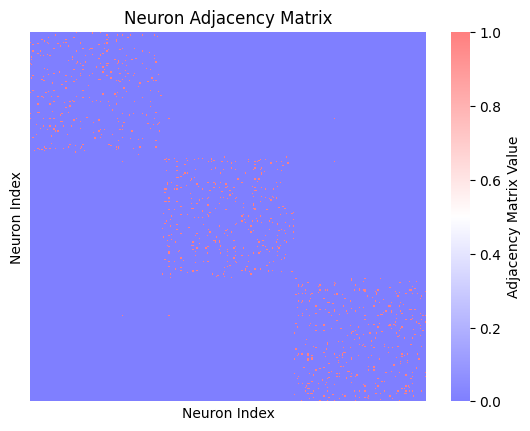

In [52]:
if not implement_neuron_modules_connections:
    # Now make it so that connection probabilties exponentially decay with distance
    distance_connection_probability_exponent_constant = 10

    # Scaling distances by the maximum distance in the space so that it is a value value between 0 and 1 for probability. 
    max_distance = np.sqrt((radius)**2 * n_dim)
    connection_probabilty_exponent = ( distance_matrix / max_distance) * distance_connection_probability_exponent_constant # Add a constant to change the strength of this value
    connection_probability = np.exp(-connection_probabilty_exponent)
    
    # Calculate the adjacency matrix as a binomial process based on connection probabilties
    A = np.random.binomial(n = 1, p = connection_probability)
    A -= np.eye(n, dtype = np.int64) # Subtract out self-connections
    edges = np.argwhere(A == 1)

elif implement_neuron_modules_connections:
    distance_connection_probability_exponent_constant = 100
    num_rich_club_neurons_per_module = 1 # Per module
    
    # Go through the different groups, connect each by their closest neurons 
    max_distance = np.sqrt((radius)**2 * n_dim)
    connection_probabilty_exponent = ( distance_matrix / max_distance) * distance_connection_probability_exponent_constant # Add a constant to change the strength of this value
    connection_probability = np.exp(-connection_probabilty_exponent)

    # Loop over the groups to connect them
    A = np.zeros((n, n))
    for group_idx in range(num_groups):
        start_index = n_per_group * group_idx
        end_index = start_index + n_per_group

        # Calculate the connections within the module
        A_sub = np.random.binomial(n = 1, p = connection_probability[start_index:end_index, start_index:end_index])

        # Fill in the full connection matrix using the sub module
        A[start_index:end_index, start_index:end_index] = A_sub

    # Remove self connections
    diag_indices = np.arange(n)
    A[diag_indices, diag_indices] = np.zeros(n)

    # Check if any neurons do not have a single connection
    no_connection_neurons = np.argwhere((np.sum(A, axis = 1) + np.sum(A, axis = 0)) == 0).flatten() # find neurons without a connection
    closest_neurons = np.argsort(distance_matrix[no_connection_neurons, :], axis = 1)[:, 1] # Find which neurons they're closest to, skip the result that is a self connection
    new_edges = np.column_stack([no_connection_neurons, closest_neurons]) # Combine into a vector
    A[new_edges[:, 0], new_edges[:, 1]] = A[new_edges[:, 0], new_edges[:, 1]] = 1 # Create double sided connection between the two neurons

    # Remove self connections
    diag_indices = np.arange(n)
    A[diag_indices, diag_indices] = np.zeros(n)

    # Find the highest degree nodes in each module, and connect them with the others
    rich_club_neurons = []
    total_degrees = np.sum(A, axis = 0) + np.sum(A, axis = 1)
    for group_idx in range(num_groups):
        start_index = n_per_group * group_idx
        end_index = start_index + n_per_group
        
        rich_club_neurons_for_module = np.argsort(-total_degrees[start_index:end_index])[:num_rich_club_neurons_per_module]
        rich_club_neurons += [rich_club_neurons_for_module + start_index] # Add them to a list, add starting index to make index the correct basis
    
    # Turn list of arrays into an array
    rich_club_neurons = np.concat(rich_club_neurons)
    rich_club_connections = np.array(np.meshgrid(rich_club_neurons, rich_club_neurons)).T.reshape(-1, 2) # Get all combinations of rich club neurons

    # Create double sided connections between all rich club neurons
    A[rich_club_connections[:, 0], rich_club_connections[:, 1]] = 1

    # Remove self connections again
    A[diag_indices, diag_indices] = np.zeros(n)
        
    # Generate the edges
    edges = np.argwhere(A == 1)


print(f'Network Density: {(np.sum(A) / (A.shape[0] * A.shape[1]) * 100):.2f}%')

if visualize_adjacency_matrix: 
    sns.heatmap(A, cmap = 'bwr', alpha = 0.5, cbar_kws={'label': 'Adjacency Matrix Value'})
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Neuron Index')
    plt.ylabel('Neuron Index')
    plt.title('Neuron Adjacency Matrix')
    plt.savefig(adjacency_matrix)

In [53]:
def GetAdjacencyMatrix(
    implement_neuron_modules_connections,
    distance_matrix,
    radius,
    n_dim,
    n_per_group = 100,
    num_groups = 3,
    distance_connection_probability_exponent_constant = None,
    num_rich_club_neurons_per_module = 1,
    visualize_adjacency_matrix = True,
    visualize_connected_network = True
):
    '''
    A function to create the adjacency matrix for the network.

    Parameters:
    ----------
        implement_neuron_modules_connections: A boolean. If True, networks will be connected as modules. If false, they will have their connection probability 

    Returns:
    -------
        A: The adjacency matrix.
        edges: A mx(n_dim) numpy array of the edges. The first column is the outgoing neuron and the second is the incoming neuron.
    '''
    
    if not implement_neuron_modules_connections:
        # Now make it so that connection probabilties exponentially decay with distance
        if distance_connection_probability_exponent_constant is None:
            distance_connection_probability_exponent_constant = 10
    
        # Scaling distances by the maximum distance in the space so that it is a value value between 0 and 1 for probability. 
        max_distance = np.sqrt((radius)**2 * n_dim)
        connection_probabilty_exponent = ( distance_matrix / max_distance) * distance_connection_probability_exponent_constant # Add a constant to change the strength of this value
        connection_probability = np.exp(-connection_probabilty_exponent)
        
        # Calculate the adjacency matrix as a binomial process based on connection probabilties
        A = np.random.binomial(n = 1, p = connection_probability)
        A -= np.eye(n, dtype = np.int64) # Subtract out self-connections
        edges = np.argwhere(A == 1)
    
    elif implement_neuron_modules_connections:
        if distance_connection_probability_exponent_constant is None:
            distance_connection_probability_exponent_constant = 100

        n = n_per_group * num_groups
        
        # Go through the different groups, connect each by their closest neurons 
        max_distance = np.sqrt((radius)**2 * n_dim)
        connection_probabilty_exponent = ( distance_matrix / max_distance) * distance_connection_probability_exponent_constant # Add a constant to change the strength of this value
        connection_probability = np.exp(-connection_probabilty_exponent)
    
        # Loop over the groups to connect them
        A = np.zeros((n, n))
        for group_idx in range(num_groups):
            start_index = n_per_group * group_idx
            end_index = start_index + n_per_group
    
            # Calculate the connections within the module
            A_sub = np.random.binomial(n = 1, p = connection_probability[start_index:end_index, start_index:end_index])
    
            # Fill in the full connection matrix using the sub module
            A[start_index:end_index, start_index:end_index] = A_sub

        # Remove self connections
        diag_indices = np.arange(n)
        A[diag_indices, diag_indices] = np.zeros(n)
    
        # Check if any neurons do not have a single connection
        no_connection_neurons = np.argwhere((np.sum(A, axis = 1) + np.sum(A, axis = 0)) == 0).flatten() # find neurons without a connection
        closest_neurons = np.argsort(distance_matrix[no_connection_neurons, :], axis = 1)[:, 1] # Find which neurons they're closest to, skip the result that is a self connection
        new_edges = np.column_stack([no_connection_neurons, closest_neurons]) # Combine into a vector
        A[new_edges[:, 0], new_edges[:, 1]] = A[new_edges[:, 0], new_edges[:, 1]] = 1 # Create double sided connection between the two neurons
    
        # Remove self connections
        diag_indices = np.arange(n)
        A[diag_indices, diag_indices] = np.zeros(n)
    
        # Find the highest degree nodes in each module, and connect them with the others
        rich_club_neurons = []
        total_degrees = np.sum(A, axis = 0) + np.sum(A, axis = 1)
        for group_idx in range(num_groups):
            start_index = n_per_group * group_idx
            end_index = start_index + n_per_group
            
            rich_club_neurons_for_module = np.argsort(-total_degrees[start_index:end_index])[:num_rich_club_neurons_per_module]
            rich_club_neurons += [rich_club_neurons_for_module + start_index] # Add them to a list, add starting index to make index the correct basis
        
        # Turn list of arrays into an array
        rich_club_neurons = np.concat(rich_club_neurons)
        rich_club_connections = np.array(np.meshgrid(rich_club_neurons, rich_club_neurons)).T.reshape(-1, 2) # Get all combinations of rich club neurons
    
        # Create double sided connections between all rich club neurons
        A[rich_club_connections[:, 0], rich_club_connections[:, 1]] = 1
    
        # Remove self connections again
        A[diag_indices, diag_indices] = np.zeros(n)
            
        # Generate the edges
        edges = np.argwhere(A == 1)
    
    
    print(f'Network Density: {(np.sum(A) / (A.shape[0] * A.shape[1]) * 100):.2f}%')
    
    if visualize_adjacency_matrix: 
        sns.heatmap(A, cmap = 'bwr', alpha = 0.5, cbar_kws={'label': 'Adjacency Matrix Value'})
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('Neuron Index')
        plt.ylabel('Neuron Index')
        plt.title('Neuron Adjacency Matrix')
        plt.savefig(adjacency_matrix)

    if visualize_connected_network:
        fig = ShowNetwork(
            pos_array = pos_array,
            edges = edges,
            A = A,
            axis_limit = radius,
            showticklabels = True,
            gridwidth = 2,
            gridcolor = 'black',
            node_size = 15,
            title = 'Neuron Graph Network',
            title_x = 0.5, 
            node_size_floor=3,
            degree_based_size_scalar=0.5
        )
        fig.write_image(network_graph_path)
        fig.show()

    return A, edges, rich_club_neurons

Network Density: 1.14%


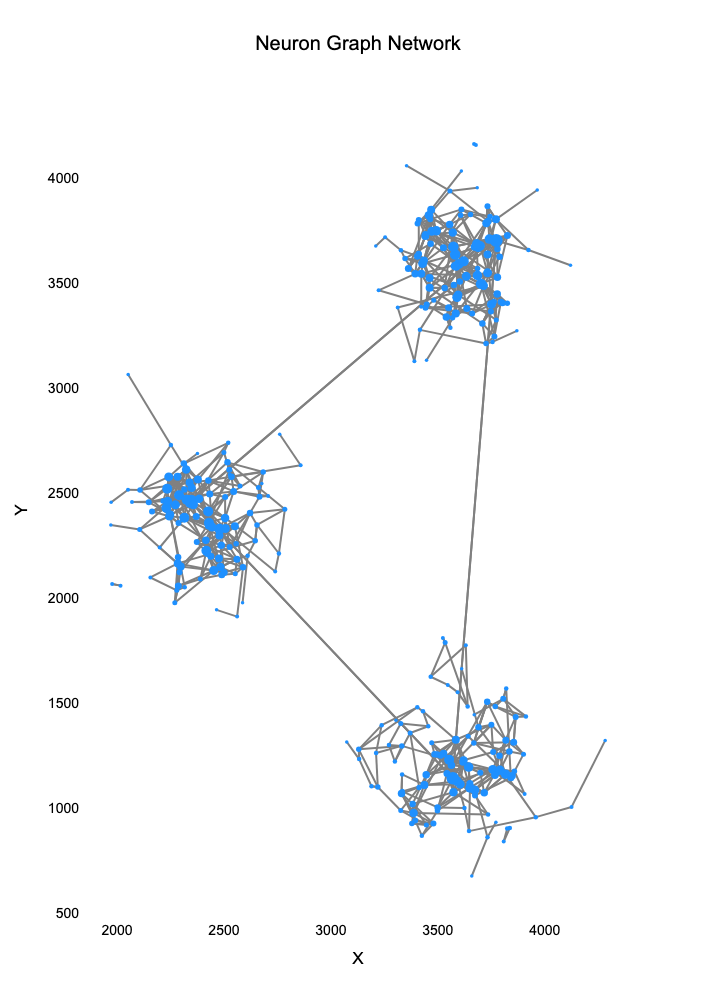

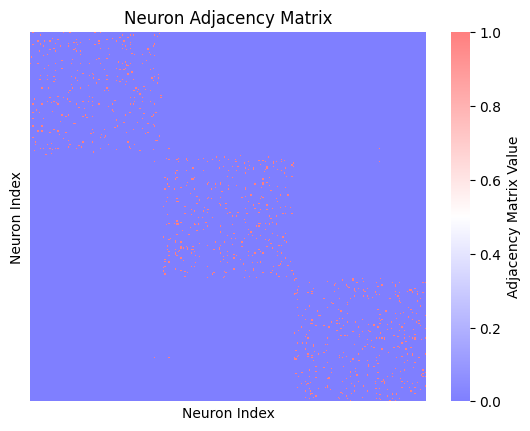

In [54]:
A, edges, rich_club_neurons = GetAdjacencyMatrix(
    implement_neuron_modules_connections,
    distance_matrix,
    radius,
    n_dim
)

In [55]:
# Make sure that no zero-degree nodes exits
degrees = (np.sum(A, axis = 0) + np.sum(A, axis = 1))
print('Num zero degree nodes:', np.sum(degrees == 0))

Num zero degree nodes: 0


##### Calculating the Time to Complete AP for each edge

In [56]:
time_to_complete_ap = PosArray_to_SignalTiming(
    pos_array, edges, config_dict
)

#### Weight distirbutions

Want to make it so random weights are centered in positive and can become inhibitory or not

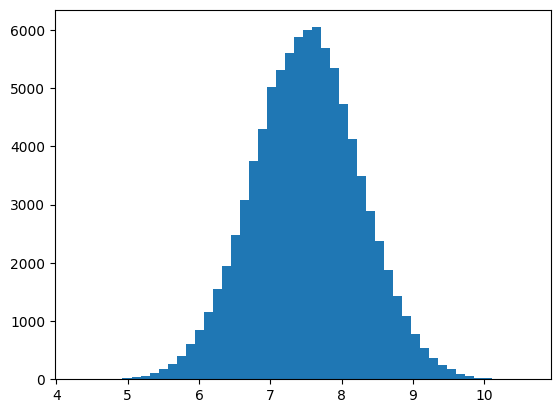

In [183]:
mean = 0.5
std = 0.05

vals = np.random.normal(
    mean, std, size = (n,n)).flatten() * 15
plt.hist(vals, bins = 50)
plt.show()

In [86]:
np.ones((n,n))

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(300, 300))

#### Creating a Function for Simulation

##### Quick Logic Check for Passing Injected Current Between Neurons

In [57]:
# Test of logic for passing on injected current from one neuron to the next
spike_idx = np.array([0, 1, 0])

# The second neuron has outgoing connections to the first and third neuron
# When it spikes, expect injected current to be going to these two neurons
B = np.array(
    [
        [0, 1, 0],
        [1, 0, 1],
        [1, 0, 0]
    ]
)

spike_idx_diag = np.diag(spike_idx)

# Find that this is the result, so the logic seems to be working
(np.array([15, 15, 15]).reshape(1, 3) @ (spike_idx_diag @ B) )

array([[15,  0, 15]])

##### Generating code for the poisson point process to have randomly injected noise to the system

In [68]:
def GeneratePoissoinPointProcess(
    n,
    q,
    num_time_steps,
    t_step_size
):
    '''
    A function to generate random noise in the network as poissoin point processes.

    Paramters:
    ---------
        q: Float. The average firing rate in hertz (1/s)
        num_time_steps: Int. Number of time steps, unitless
        t_step_size: Float. The step size in time (ms)
        

    Returns:
    -------
        external_noise_array: Numpy Array. The first column is the node index that should get injected current and the second column is the time step when it should get that injected current.
    
    '''
    total_time_ms = num_time_steps * t_step_size # Total time in milliseconds (ms)
    
    # Convert total time to seconds
    total_time_s = total_time_ms / 1000  # 1000 ms in a second
    lam = q * total_time_s # Create lambda from the number of seconds that it's being run and using the expected firing rate for each second
    
    # Find the external noise
    external_noise = np.random.poisson(lam, size = n)
    
    # An array to keep the values for the external noise to the neuron
    # Beacuse it'd be a sparse matrix to have all neurons on rows and all time steps on columns
    # I'm going to create an array with the first column being the neuron and the second being a time step that it should fire
    external_noise_array = []
    
    # Determine when those firings should happen
    for i in range(n):
        # Find where the neuron should fire
        firing_locations = np.random.choice(np.arange(0, num_time_steps), size = external_noise[i], replace = False)
        external_noise_array += [np.column_stack([np.repeat(i, external_noise[i]), firing_locations])]
    
    # Concatenate the list of numpy arrays into a single numpy array 
    external_noise_array = np.concat(external_noise_array)

    return external_noise_array

##### Looking at the exponential decay of injected current

In [140]:
t_step_size * 1000

0.1

In [146]:
injected_current_over_time[0]

np.int64(15)

In [152]:
15 * np.exp(-injected_current_decay_parameter)

np.float64(14.702980099601328)

In [147]:
(t_step_size)/ 5e-3

0.02

In [148]:
(t_step_size * 1000)/ 5

0.02

In [155]:
injected_current_over_time[1]

np.int64(14)

In [158]:
15 * np.exp(-injected_current_decay_parameter) * np.exp(-injected_current_decay_parameter)

np.float64(14.411841587284846)

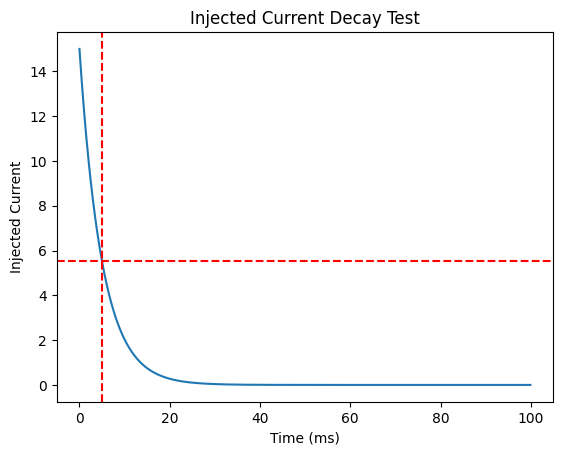

In [166]:
num_steps = 1000
injected_current_decay_parameter = (t_step_size)/ 5e-3 # 0.01

time = np.arange(num_steps) * t_step_size * 1000
injected_current_over_time = np.array([15] * num_steps, dtype = np.float64)

for i in range(injected_current_over_time.shape[0]):
    if i != 0:
        injected_current_over_time[i] = injected_current_over_time[i-1] * np.exp(-injected_current_decay_parameter)

plt.plot(time, injected_current_over_time)
plt.xlabel('Time (ms)')
plt.ylabel('Injected Current')
plt.title('Injected Current Decay Test')
plt.axhline(y = 15 * ((1 / np.exp(1))), color = 'r', linestyle='--')
plt.axvline(x = 5, color = 'r', linestyle = '--')
plt.show()

##### Exponential connection probability

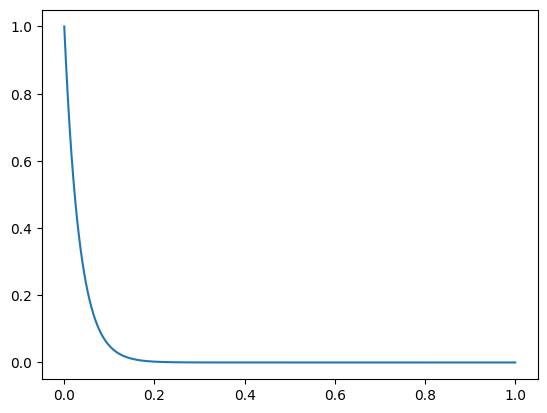

In [179]:
distances = np.linspace(0, 1, 1000)
distance_connection_probability_exponent_constant = 30
connection_probabilty_exponent = distances * distance_connection_probability_exponent_constant
probabilities = np.exp(-connection_probabilty_exponent)
plt.plot(distances, probabilities)

##### End of firing index logic

In [70]:
# Create an end of firing index
end_of_firing_index = np.zeros(edges.shape[0], dtype = np.bool_)
end_of_firing_index[[0, 10, 15]] = 1

# Create a matrix to hold the injected current values

# Find the edges who have ended their firing
end_of_firing_edges = edges[end_of_firing_index, :]

In [71]:
injected_current_from_each_edge = np.random.rand(edges.shape[0])

In [72]:
w = np.zeros((n,n))
w[end_of_firing_edges[:, 0], end_of_firing_edges[:, 1]] = injected_current_from_each_edge[end_of_firing_index]

In [73]:
w * A # Filter

array([[0.        , 0.        , 0.96007589, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(300, 300))

##### Logic for pre-synaptic neuron and updating t-index based on this

In [74]:
# Make a random spike index
spike_idx = np.zeros(n, dtype = np.bool_)
spike_idx[[0, 10, 15]] = 1

# Get pre-synaptic neurons based on if they fired
presynaptic_neurons = np.argwhere(spike_idx == 1).flatten()

# Find edges with this presynaptic axon
start_ap_counter_idx = np.isin(edges[:, 0], presynaptic_neurons)
edges[start_ap_counter_idx]
# t_index[start_ap_counter_idx] += 1 # Start their t_index counter

array([[ 0,  2],
       [ 0, 25],
       [ 0, 30],
       [ 0, 49],
       [ 0, 53],
       [10,  2],
       [10,  8],
       [10, 36],
       [10, 49],
       [10, 70],
       [10, 76],
       [10, 94],
       [15,  7],
       [15, 19],
       [15, 35],
       [15, 38]])

##### Actual Simulation Function

In [75]:
# Function for Simulation
def SimulateNeurons(
    pos_array,
    edges,
    weights,
    num_time_steps,
    time_to_complete_ap = None,
    q = 1, # Random process added in
    constant_injected_current_index = None,
    vary_neuron_type = False,
    resting_voltage = -70,
    default_a = 0.02,
    default_b = 0.2,
    default_c = -65,
    default_d = 8,
    highest_injected_current = 15,
    t_step_size = 1,
    injected_current_decay_parameter = 0,
    diagnostic_printing = False
):
    '''

    A function to simulate the neurons for a given period of time.

    Parameters:
    ----------

    Returns:
    -------

    '''
    # Create a named tuple object to save results for later
    SimulationResults = namedtuple(
        'SimulationResults', 
        [
            'voltages', 'us', 'injected_current',
            'spikes', 'q', 'num_time_steps', 't_step_size',
            't_index'
        ]
    )

    # Get the number of neurons and edges in the simulation
    n = pos_array.shape[0]
    m = edges.shape[0]
    
    # Create arrays to save the voltages, injected_current, and u's at each time step
    voltages_over_time = np.zeros((num_time_steps, n), dtype = np.float64)
    izhikevich_us_over_time = np.zeros((num_time_steps, n), dtype = np.float64)
    injected_current_over_time = np.zeros((num_time_steps, n), dtype = np.float64)
    spikes_over_time = np.zeros((num_time_steps, n), dtype = np.float64)

    if vary_neuron_type == True:
        # Fill this in more 
        izhikevich_a = np.array([default_a] * n, dtype = np.float64)
        izhikevich_b = np.array([default_b] * n, dtype = np.float64)
        izhikevich_c = np.array([default_c] * n, dtype = np.float64)
        izhikevich_d = np.array([default_d] * n, dtype = np.float64)
        
    else:
        # Have all neurons be regular spiking Izhikevich Neurons
        izhikevich_a = np.array([default_a] * n, dtype = np.float64)
        izhikevich_b = np.array([default_b] * n, dtype = np.float64)
        izhikevich_c = np.array([default_c] * n, dtype = np.float64)
        izhikevich_d = np.array([default_d] * n, dtype = np.float64)        

    # Create an array for the injected current
    highest_injected_current_vec = np.array([highest_injected_current]*n, dtype = np.float64).reshape(1, n)

    # Create arrays for the starting voltages and izhikeivch_us
    voltages = np.array([resting_voltage] * n, dtype = np.float64)
    izhikevich_us = default_b * voltages # np.array([], dtype = np.float64)
    injected_current = np.zeros(n, dtype = np.float64)
    spike_idx = np.zeros(n, dtype = np.float64)

    # Generate random input to the system
    external_noise_array = GeneratePoissoinPointProcess(n, q, num_time_steps, t_step_size * 1000) # Convert the t_step_size that is in seconds to ms

    # Incorporating timing dynamics
    if time_to_complete_ap is not None:
        # Create a counter for the signal along an axon
        t_index = np.zeros(m, dtype = np.int64)
        t_index_over_time = np.zeros((num_time_steps, m), dtype = np.float64)
        
    for t in range(num_time_steps):
        # Create a new array for random noise at this time step
        random_noise_at_time_step = np.zeros(n, dtype = np.float64)
        
        # Create a diagonal matrix such that that diagonal entry says if this neuron spiked or not
        spike_idx_diag = np.diag(spike_idx)

        # Incorporate timing if passed as a parameter
        if time_to_complete_ap is not None:
            # Check if any axons are actively carrying signal
            update_idx = t_index > 0
            t_index[update_idx] += 1 # If axon is carrying signal, update the timing for how many time steps its been since initial firing

            # Look for axons whose firing ended now
            ended_firing_index = t_index >= time_to_complete_ap
            t_index[ended_firing_index] = 0 # Reset their t_index now to 0

            ## Calculate the injected current at time step taking into account timing
            # Find the edges that finished firing, including pre and post-synaptic neurons
            end_of_firing_edges = edges[ended_firing_index, :]

            # Create a matrix to hold the indices of which nodes are getting injected current
            nodes_getting_injected_current_mat = np.zeros((n,n), dtype = np.float64)
            nodes_getting_injected_current_mat[end_of_firing_edges[:, 0], end_of_firing_edges[:, 1]] = 1 # Fill in with a 1 as an indicator
            
            # Add injected current to the post-synaptic neurons
            spike_adjusted_weights_mat = nodes_getting_injected_current_mat * weights # Filter weights based on if the axon finished firing
            injected_current_at_step = highest_injected_current_vec @ spike_adjusted_weights_mat 
            
            # Update the total injected current for the neuron, to take into account any previous
            injected_current += injected_current_at_step.reshape(-1)

        else:
            ## Calculate the injected current at time step without taking into account timing
            # Multiply spike_idx_diag by weights to select the rows (neurons) that have spiked.
            spike_adjusted_weights_mat = spike_idx_diag @ weights 

            # Then multiply by the injected current vec to sum down the column
            # getting the total injected current to the neuron at this time
            injected_current_at_step = highest_injected_current_vec @ spike_adjusted_weights_mat

            # Update the total injected current for the neuron, to take into account any previous
            injected_current += injected_current_at_step.reshape(-1)

        # Check if any neurons are getting random injected current at this time step
        if q != 0:
            external_noise_at_this_time_step_idx = external_noise_array[:, 1] == t
            neurons_getting_external_noise_at_this_time_step = external_noise_array[external_noise_at_this_time_step_idx, 0]
            random_noise_at_time_step[neurons_getting_external_noise_at_this_time_step] = highest_injected_current
    
            if (np.sum(external_noise_at_this_time_step_idx) != 0) and diagnostic_printing:
                print(f'{t}')
                print('external_noise_at_this_time_step_idx:', external_noise_at_this_time_step_idx)
                print('random_noise_at_time_step:', random_noise_at_time_step, '\n')

            # Add the noise to the injected current at this time step
            injected_current_at_step = random_noise_at_time_step
            
            # Update the total injected current for the neuron, to take into account any previous
            injected_current += injected_current_at_step.reshape(-1)

        if constant_injected_current_index is not None:
            # If there are neurons being constantly injected with current, add that current
            constant_injected_current_needed_idx = injected_current[constant_injected_current_index] < highest_injected_current
            constant_injected_current_needed_idx = constant_injected_current_index[constant_injected_current_needed_idx]
            injected_current[constant_injected_current_needed_idx] = highest_injected_current
        
        # Update voltages, us, and capture nodes that spiked
        voltages, izhikevich_us, spike_idx = IzhikevichNeuron(
            voltages = voltages,
            izhikevich_us = izhikevich_us,
            injected_current = injected_current,
            izhikevich_a = izhikevich_a,
            izhikevich_b = izhikevich_b,
            izhikevich_c = izhikevich_c,
            izhikevich_d = izhikevich_d,
            spike_threshold = 30,
            t_step_size = t_step_size * 1000, # Convert the t_step_size that is in seconds to ms
            diagnostic_printing = diagnostic_printing
        )

        if time_to_complete_ap is not None:
            ## Update the t_index values for the edges that have the pre-synaptic neuron firing            
            # Get pre-synaptic neurons based on if they fired
            presynaptic_neurons = np.argwhere(spike_idx == 1).flatten()
            
            # Find edges with this presynaptic axon
            start_ap_counter_idx = np.isin(edges[:, 0], presynaptic_neurons)
            t_index[start_ap_counter_idx] += 1 # Start their t_index counter
        
        # Save results to larger matrices
        voltages_over_time[t, :] = voltages
        izhikevich_us_over_time[t, :] = izhikevich_us
        injected_current_over_time[t, :] = injected_current
        spikes_over_time[t, :] = spike_idx
        if time_to_complete_ap is not None:
            t_index_over_time[t, :] = t_index

        # Exponential decay to allow the injected current to leak
        injected_current *= np.exp(-injected_current_decay_parameter)

    if time_to_complete_ap is None:
        t_index_over_time = None
        
    # Compile results in a named tuple for ease of use
    out = SimulationResults(
        voltages = voltages_over_time,
        us = izhikevich_us_over_time,
        injected_current = injected_current_over_time,
        spikes = spikes_over_time,
        q = q,
        num_time_steps = num_time_steps,
        t_step_size = t_step_size * 1000, # Convert the t_step_size from seconds to ms
        t_index = t_index_over_time
    )

    return out

#### Example of Running the Simulation 

In [76]:
rich_club_neurons

array([ 94, 105, 264])

In [77]:
## Parameters ##
# Load in the configuration dictionary
config_dict = LoadYAMLFile('config-file.yaml')

# Single values
q = 0
np.random.seed(seed)
constant_injected_current_index = np.random.choice(rich_club_neurons, 1, replace = False) # np.array([0, 1, 2])
injected_current_decay_parameter = 0.01
num_time_steps = config_dict['timing']['num_time_steps']
t_step_size = float(config_dict['timing']['t_step_size'])

# Booleans for which aspects to include in the networks
implement_timing = True # Determines if the node positions determine signal speeds
implement_constant_weights = True # Determiens if weights should be constant

################

start_time = time.time()

## Logical updates based on parameters ##
if implement_timing:
    time_to_complete_ap = PosArray_to_SignalTiming(pos_array, edges, config_dict)
else:
    time_to_complete_ap = None

if implement_constant_weights:
    weight_adjustement = 0.10
else:
    weight_adjustement = 1

################


## Simulation ##
out = SimulateNeurons(
    pos_array = pos_array, 
    edges = edges, 
    weights = A * weight_adjustement, 
    num_time_steps = num_time_steps,
    q = q,
    constant_injected_current_index = constant_injected_current_index,
    t_step_size = t_step_size,
    injected_current_decay_parameter = injected_current_decay_parameter,
    time_to_complete_ap=time_to_complete_ap
)
################

print('Time for Execution:', time.time() - start_time)

Time for Execution: 0.7733330726623535


In [79]:
help(out)

Help on SimulationResults in module __main__ object:

class SimulationResults(builtins.tuple)
 |  SimulationResults(voltages, us, injected_current, spikes, q, num_time_steps, t_step_size, t_index)
 |  
 |  SimulationResults(voltages, us, injected_current, spikes, q, num_time_steps, t_step_size, t_index)
 |  
 |  Method resolution order:
 |      SimulationResults
 |      builtins.tuple
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getnewargs__(self)
 |      Return self as a plain tuple.  Used by copy and pickle.
 |  
 |  __repr__(self)
 |      Return a nicely formatted representation string
 |  
 |  _asdict(self)
 |      Return a new dict which maps field names to their values.
 |  
 |  _replace(self, /, **kwds)
 |      Return a new SimulationResults object replacing specified fields with new values
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  _make(iterable) from builtins.type
 |      Make a

##### Create a Voltage Plot of the Simulation

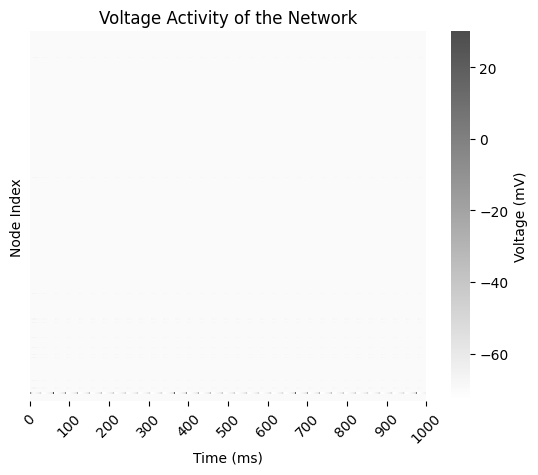

In [70]:
PlotVoltageTrace(
    out, flip_axes=True, 
    include_node_indices=False,
    cmap = 'grey_r'
)

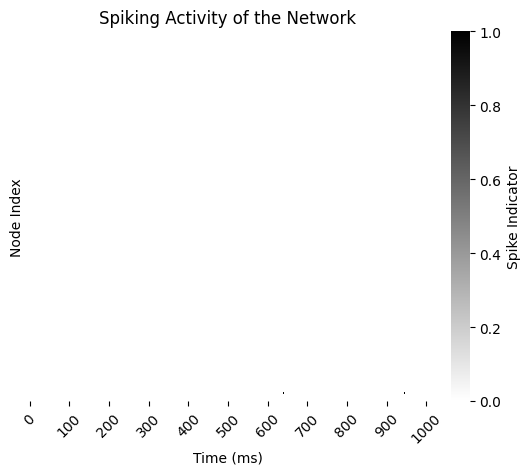

In [71]:
PlotSpikeTrace(
    out, flip_axes=True,
    include_node_indices=False,
    cmap = 'grey_r'
)

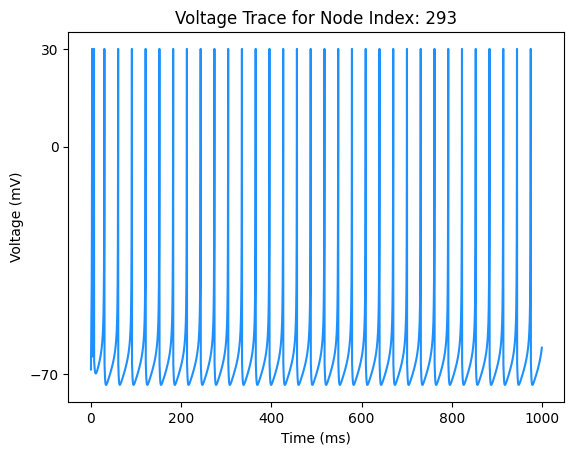

In [72]:
PlotIndividualNodeTrace(out, constant_injected_current_index[0])

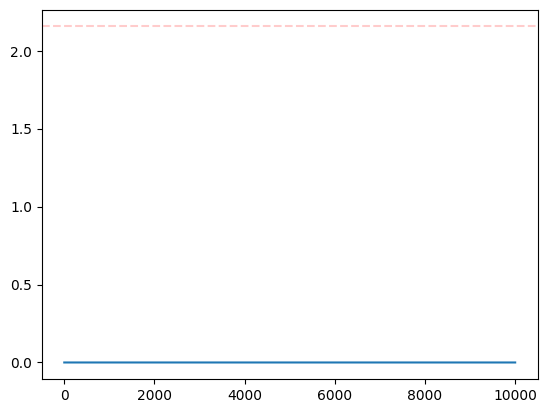

In [47]:
plt.plot(np.arange(out.t_index.shape[0]), out.t_index[:, 0])
plt.axhline(y = time_to_complete_ap[0], linestyle = '--', color = 'r', alpha = 0.2)
plt.show()

### Create a table of parameters to test

#### Simulations over different features


### Impact of Different Features

#### PCA

In [ ]:
def PCA(out, num_dim_pca):
    '''
    A function to calculte the PCA reduction of the voltage time series.

    Parameters:
    ----------
        out: NamedTuple. The returned tuple that has the voltages.
        num_dim_pca: The number of principle components to return.

    Returns:
    -------
        x_reduced: The PCA of the voltage derivatives.
        eig: The sorted eigenvalues of the covariance matrix.
        eig_vecs: The sorted eigenvectors of the covariance matrix.
    '''
    # Calculate based on the voltages over time
    x = out.voltages.copy()
    
    # Normalize the voltages
    x_mean = np.mean(x, axis = 0)
    x_std = np.std(x, axis = 0)
    
    # Manually control for x_std == 0, neurons that didn't fire
    zero_std_idx = x_std == 0
    x[:, zero_std_idx] = np.zeros((x.shape[0], np.sum(zero_std_idx)), dtype = np.float64)
    x[:, ~zero_std_idx] = (x[:, ~zero_std_idx] - x_mean[~zero_std_idx]) / x_std[~zero_std_idx]
    
    # Manually calculate the change in the signal over time
    x_d = np.concat(
        [
            np.zeros(n, dtype = np.float64).reshape(1, n), # Saying that at first time point it's a 0 derivative
            np.diff(x, axis = 0) / (t_step_size * 1000) # Calculating the derivative
        ]
    )
    
    x_cov = (1 / (x.shape[0] - 1)) * (x_d.T @ x)
    
    # Calculate the eigenvectors of the covariance matrix (Our principle components)
    eig, eig_vecs = np.linalg.eig(x_cov)
    eig, eig_vecs = eig.real, eig_vecs.real # Remove imaginary portion in case of numerical instability
    
    # Sort the eigenvectors, negative so it's descending
    sort_idx = np.argsort(-eig)
    
    eig = eig[sort_idx]
    eig_vecs = eig_vecs[:, sort_idx]

    projection_vecs = eig_vecs[:, :num_dim_pca] # Select the eigenvectors

    # Project into lower dimensional space
    x_reduced = x_d @ projection_vecs

    return x_reduced, eig, eig_vecs

In [57]:
# Parameters for what to visualize 
visualize_plotly = False

In [48]:
# Calculate based on the voltages over time
x = out.voltages.copy()

# Normalize the voltages
x_mean = np.mean(x, axis = 0)
x_std = np.std(x, axis = 0)

# Manually control for x_std == 0, neurons that didn't fire
zero_std_idx = x_std == 0
x[:, zero_std_idx] = np.zeros((x.shape[0], np.sum(zero_std_idx)), dtype = np.float64)
x[:, ~zero_std_idx] = (x[:, ~zero_std_idx] - x_mean[~zero_std_idx]) / x_std[~zero_std_idx]

# Manually calculate the change in the signal over time
x_d = np.concat(
    [
        np.zeros(n, dtype = np.float64).reshape(1, n), # Saying that at first time point it's a 0 derivative
        np.diff(x, axis = 0) / (t_step_size * 1000) # Calculating the derivative
    ]
)

x_cov = (1 / (x.shape[0] - 1)) * (x_d.T @ x)

# Calculate the eigenvectors of the covariance matrix (Our principle components)
eig, eig_vecs = np.linalg.eig(x_cov)
eig, eig_vecs = eig.real, eig_vecs.real # Remove imaginary portion in case of numerical instability

# Sort the eigenvectors, negative so it's descending
sort_idx = np.argsort(-eig)

eig = eig[sort_idx]
eig_vecs = eig_vecs[:, sort_idx]

In [49]:
# Previous attempt
# # Calculate based on the voltages over time
# x = out.voltages

# # Normalize the voltages
# x_mean = np.mean(x, axis = 0)
# x_std = np.std(x, axis = 0)
# x = x - x_mean # Center the data

# # Manually control for x_std == 0
# zero_std_idx = x_std == 0
# x[:, zero_std_idx] = np.zeros((x.shape[0], np.sum(zero_std_idx)), dtype = np.float64)
# x[:, ~zero_std_idx] = (x[:, ~zero_std_idx] - x_mean[~zero_std_idx]) / x_std[~zero_std_idx]

# # Get the time derivatives of voltages
# # x_d = np.gradient(x)[0] # Get the first derivative for each

# # Calculate the Covariance matrix
# x_cov = x_d.T @ x_d

In [50]:
num_dim_pca = 2 # Define how many dimensions to look at
projection_vecs = eig_vecs[:, :num_dim_pca] # Select the eigenvectors

# Project into lower dimensional space
x_reduced = x_d @ projection_vecs

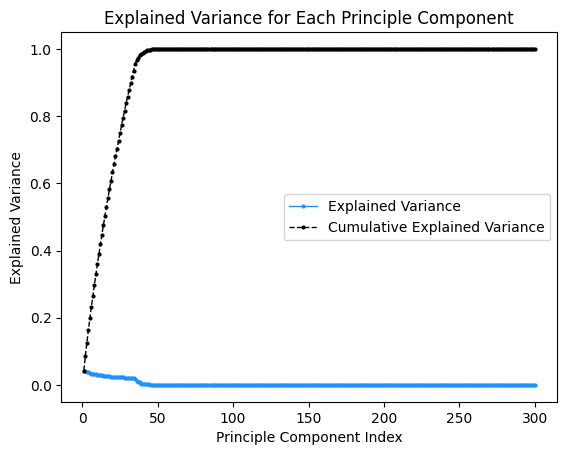

In [51]:
PlotExplainedVariance(eig)

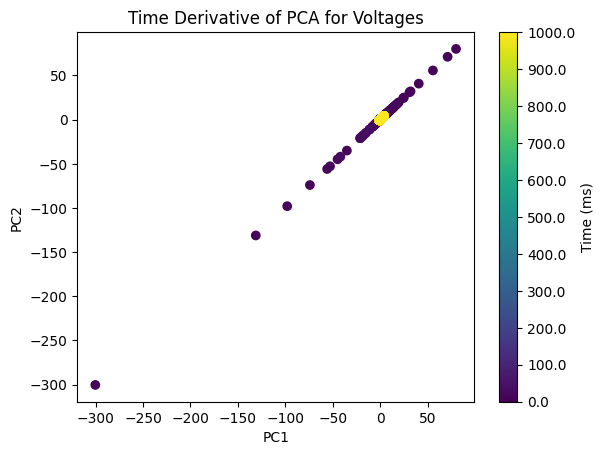

In [52]:
PlotPCA(out, x_reduced)

In [58]:
# Parameters
if visualize_plotly:
    cmap = cm.viridis

    cmap_norm = c.Normalize(vmin = 0, vmax = num_time_steps)
    node_colors = cmap(cmap_norm(np.arange(0, num_time_steps)))
    
    showticklabels = False
    background_color = 'white'
    gridcolor='grey'
    gridwidth=1
    node_size = 4
    title_font_color = 'black'
    font_size = 14
    title = 'Lower Dimensional Representation'
    
    title_x = 0.5
    xaxis_title = 'PCA 1'
    yaxis_title = 'PCA 2'
    zaxis_title = 'Time (ms)'
    
    axis_titles = [xaxis_title, yaxis_title, zaxis_title]
    
    plot_data = np.column_stack([x_reduced, np.arange(x_reduced.shape[0])])
    
    nodes=[
        dict(
            type='scatter3d',
            x=[plot_data[k][0]],
            y=[plot_data[k][1]],
            z=[plot_data[k][2]],
            mode='markers',
            marker=dict(
                size=node_size, color= e
            ),
            showlegend = False,
        ) for k, e in enumerate(node_colors) 
    ]
    
    axes = [dict(
        showbackground=True,
        showline=True,
        zeroline=True,
        showgrid=True,
        showticklabels=showticklabels,
        title=title,
        backgroundcolor = background_color,
        gridcolor = gridcolor,
        gridwidth = gridwidth
    ) for title in axis_titles]
    
    scene = dict(
        xaxis=dict(axes[0]),
        yaxis=dict(axes[1]),
        zaxis=dict(axes[2])
    )
    
    layout = go.Layout(
        title={
            'text': title,
            'x': title_x
        },
        # xaxis_title=xaxis_title,
        # yaxis_title=yaxis_title,
        width=1000,
        height=1000,
        showlegend=False,
        scene=scene,
         margin=dict(
            t=100
        ),
        hovermode='closest',
        font = {
            'family': 'Arial',
            'color': title_font_color,
            'size': font_size
        }
    )
    
    fig = go.Figure(
        data = nodes,
        layout = layout
    )
    fig.write_image('figures/plotly-pca.png')

### Explanation of Different Dynamics

# 8. Fit an Appropriate Model

Using the data you generated in your simulation, fit an appropriate model, such as HAVOK or SINDy, or even some kind of elaborate neural network, just has to be appropriate. Use it to predict your data (pick your favorite CV method or equivalent). 

You may assume any level of access you desire to potential “measurements” of a neuron (for example, if your model has a voltage variable that would normally, in biology, be impossible to measure non-destructively or precisely, you have a perfect measurement of it. You need to know the exact number of synapses or the exact geometric structure, sure).  

i) Tell us why you chose the model you did, justify it. How did it do In its prediction?

ii) What is the information that your chosen model needs to perform optimally? If your model were the data generating model of reality, what would that imply about the scientific study of those neurons?

iii)  My goal here:  For you to see how you approach the task of analyzing complex systems data, in a scenario where for the one time in your life you have omniscient knowledge about the data generating process.

### Fitting the Model

### Cross Validation

### Description of Model Choices